<a href="https://colab.research.google.com/github/Bani-Talebi/Electricity-Price-Forecasting/blob/master/LoadQuantile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from scipy.stats import norm

from sklearn import ensemble

import tensorflow as tf
from tensorflow import keras
from google.colab import files

In [ ]:
uo=files.upload()

Saving LoadPool.csv to LoadPool (1).csv


In [ ]:
DF=pd.read_csv('LoadPool (1).csv',index_col=0,parse_dates=True)

train_labels=DF['2015':'2018']['Ontario Demand'].values
test_labels=DF['2019']['Ontario Demand'].values

DF.drop(columns=['Ontario Demand'],inplace=True)

train_data=DF['2015':'2018'].values
test_data=DF['2019'].values

#Keras and Tensorflow Settings
EPOCHS = 200
BATCH_SIZE = 64
UNITS = 128
sns.set_style('white')
#DPI = 200
#mpl.rc('savefig', dpi=DPI)
#mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 3.5, 2.8  # Default.
mpl.rcParams['font.sans-serif'] = 'STIXGeneral'
mpl.rcParams['font.family'] = 'STIXGeneral'

# Set title text color to dark gray (https://material.io/color) not black.
#TITLE_COLOR = '#212121'
#mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
#AXIS_COLOR = '#757575'
#mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
#mpl.rcParams['xtick.color'] = AXIS_COLOR
#mpl.rcParams['ytick.color'] = AXIS_COLOR
#Make DataFrames
column_names = DF.columns

train_df = pd.DataFrame(train_data, columns=column_names)
test_df = pd.DataFrame(test_data, columns=column_names)
#Normalize
mean = train_df.mean(axis=0)
std = train_df.std(axis=0)
train_df = (train_df - mean) / std
test_df = (test_df - mean) / std

x_train = train_df.XGB
x_test = test_df.XGB

#Denormalize
def denorm_XGB(x):
    return x * std.XGB + mean.XGB

x_train_denorm = denorm_XGB(x_train)
x_test_denorm = denorm_XGB(x_test)

#Reformat data for statsmodels.
X_train = sm.add_constant(x_train)
X_test = sm.add_constant(x_test)
x_train_expanded = np.expand_dims(x_train, 1)
x_test_expanded = np.expand_dims(x_test, 1)
train_labels_expanded = np.expand_dims(train_labels, 1)

#Initialize result
#Dataset per method, quantile, and x value.
#####METHODS = ['Quantile Regression', 'Gradient Boosting', 'Neural Network']

METHODS = ['QRA', 'GBR']
QUANTILES = [0.05,0.10,0.15,0.20,0.25,0.30, 0.35,0.40,0.45,0.50, 0.55,0.60,0.65, 0.70,0.75,0.80,0.85, 0.90,0.95]
# QUANTILES.reverse()  # Test out to see if we're getting different results.

quantiles_legend = [str(int(q * 100)) + 'th percentile' for q in QUANTILES]

sns.set_palette(sns.color_palette('Blues', len(QUANTILES)))
sns.set_palette(sns.color_palette('Blues'))
# Set dots to a light gray
#dot_color = sns.color_palette('coolwarm', 3)[1]

preds = np.array([(method, q, x) 
                  for method in METHODS 
                  for q in QUANTILES
                  for x in x_test])
preds = pd.DataFrame(preds)
preds.columns = ['method', 'q', 'x']
preds = preds.apply(lambda x: pd.to_numeric(x, errors='ignore'))

preds['label'] = np.resize(test_labels, preds.shape[0])

#Quantile loss example
# pandas version rather than Keras.
def quantile_loss(q, y, f):
    # q: Quantile to be evaluated, e.g., 0.5 for median.
    # y: True value.
    # f: Fitted or predicted value.
    e = y - f
    return np.maximum(q * e, (q - 1) * e)

#QuantReg
quantreg = sm.QuantReg(train_labels, X_train)  # Don't fit yet, since we'll fit once per quantile.
preds.loc[preds.method == 'QRA', 'pred'] = np.concatenate([quantreg.fit(q=q).predict(X_test) for q in QUANTILES]) 

np.random.seed(7)
tf.random.set_seed(7)


In [ ]:
#Gradient boosted trees
def gb_quantile(X_train, train_labels, X, q):
    gbf = ensemble.GradientBoostingRegressor(loss='quantile', alpha=q,
                                             n_estimators=150,
                                             max_depth=5,
                                             learning_rate=0.045, min_samples_leaf=9,
                                             min_samples_split=9)
    gbf.fit(X_train, train_labels)
    return gbf.predict(X)
preds.loc[preds.method == 'GBR', 'pred'] = np.concatenate(
    [gb_quantile(X_train, train_labels, X_test, q) for q in QUANTILES]) 


def tilted_loss(q, y, f):
    e = (y - f)
    return keras.backend.mean(keras.backend.maximum(q * e, (q - 1) * e), axis=-1)
#optimizer = tf.train.AdamOptimizer(0.001)
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [ ]:
preds['x_denorm'] = denorm_XGB(preds.x)

#Compare quantile loss
preds['quantile_loss'] = quantile_loss(preds.q, preds.label, preds.pred)

        quantile_loss
method               
GBR        135.665409
QRA        136.280881
method         GBR         QRA
q                             
0.05     65.663124   68.628605
0.10     96.517142   99.034426
0.15    118.022806  120.436326
0.20    134.598953  136.112328
0.25    147.237715  148.001770
0.30    156.551772  157.038018
0.35    163.254367  163.428273
0.40    167.656655  167.657144
0.45    170.224200  169.912054
0.50    170.605533  170.282580
0.55    169.278009  168.790655
0.60    165.699952  165.381001
0.65    160.198715  160.030635
0.70    152.484899  152.536418
0.75    142.095021  142.640991
0.80    129.378576  129.879546
0.85    113.121873  113.552550
0.90     91.855050   92.591367
0.95     63.198407   63.402059


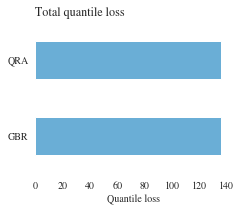

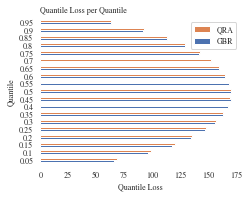

In [ ]:



def plot_loss_comparison(preds):
    overall_loss_comparison = preds[~preds.quantile_loss.isnull()].\
      pivot_table(index='method', values='quantile_loss').\
      sort_values('quantile_loss')
    # Show overall table.
    print(overall_loss_comparison)
    
    


  
    # Plot overall.
    with sns.color_palette('Blues', 1):
        ax = overall_loss_comparison.plot.barh()
        plt.title('Total quantile loss', loc='left')
        sns.despine(left=True, bottom=True)
        plt.xlabel('Quantile loss')
        plt.ylabel('')
        ax.legend_.remove()
        #plt.savefig('Total Quantile Loss..pdf',dpi=300)
        #files.download('Total Quantile Loss.pdf')
  
    # Per quantile.
    per_quantile_loss_comparison = preds[~preds.quantile_loss.isnull()].\
        pivot_table(index='q', columns='method', values='quantile_loss')
    # Sort by overall quantile loss.
    per_quantile_loss_comparison = \
        per_quantile_loss_comparison[overall_loss_comparison.index]
    print(per_quantile_loss_comparison)
  
    # Plot per quantile.
    with sns.color_palette('deep'):
        plt.rcParams['font.size']=8
        plt.rcParams['figure.autolayout']=True
        plt.rcParams['axes.titlesize']=8
        plt.rcParams['axes.labelsize']=8
        plt.rcParams['lines.linewidth']=1
        plt.rcParams['lines.markersize']=2
        plt.rcParams['legend.fontsize']=8
        plt.rcParams['mathtext.fontset']='stix'
        plt.rcParams['mathtext.fontset']='custom'
        plt.rcParams['legend.numpoints']=1

        ax = per_quantile_loss_comparison.plot.barh()
        plt.title('Quantile Loss per Quantile', loc='left')
        sns.despine(left=True, bottom=True)
        handles, labels = ax.get_legend_handles_labels()
        plt.xlabel('Quantile Loss')
        plt.ylabel('Quantile')
        # Reverse legend.
        ax.legend(reversed(handles), reversed(labels))
        #plt.savefig('Per Quantile Loss.png',dpi=300)
        #files.download('Per Quantile Loss.png')
plot_loss_comparison(preds)




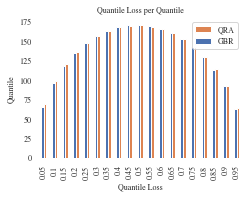

In [ ]:
#sns.set_style('dark')
def plot_loss_comparison(preds):
    overall_loss_comparison = preds[~preds.quantile_loss.isnull()].\
      pivot_table(index='method', values='quantile_loss').\
      sort_values('quantile_loss')
    # Show overall table.
    #print(overall_loss_comparison)
    
    


  

  
    # Per quantile.
    per_quantile_loss_comparison = preds[~preds.quantile_loss.isnull()].\
        pivot_table(index='q', columns='method', values='quantile_loss')
    # Sort by overall quantile loss.
    per_quantile_loss_comparison = \
        per_quantile_loss_comparison[overall_loss_comparison.index]
  
    # Plot per quantile.
    with sns.color_palette('deep'):
        plt.rcParams['font.family']='STIXGeneral'
        plt.rcParams['font.size']=8
        plt.rcParams['figure.autolayout']=True
        plt.rcParams['axes.titlesize']=8
        plt.rcParams['axes.labelsize']=8
        plt.rcParams['lines.linewidth']=1
        plt.rcParams['lines.markersize']=2
        plt.rcParams['legend.fontsize']=8
        plt.rcParams['mathtext.fontset']='stix'
        plt.rcParams['mathtext.fontset']='custom'
        plt.rcParams['legend.numpoints']=1

        ax = per_quantile_loss_comparison.plot.bar()
        plt.title('Quantile Loss per Quantile')
        sns.despine(left=True, bottom=True)
        handles, labels = ax.get_legend_handles_labels()
        plt.xlabel('Quantile Loss')
        plt.ylabel('Quantile')
        # Reverse legend.
        ax.legend(reversed(handles), reversed(labels))
        #plt.savefig('Per Quantile Loss.png',dpi=300)
        #files.download('Per Quantile Loss.png')
plot_loss_comparison(preds)

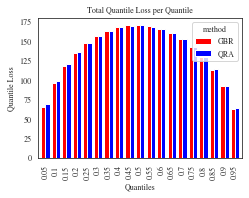

In [ ]:

overall_loss_comparison = preds[~preds.quantile_loss.isnull()].\
  pivot_table(index='method', values='quantile_loss').\
  sort_values('quantile_loss')
# Show overall table.

# Per quantile.
per_quantile_loss_comparison = preds[~preds.quantile_loss.isnull()].\
    pivot_table(index='q', columns='method', values='quantile_loss')
# Sort by overall quantile loss.
per_quantile_loss_comparison = \
    per_quantile_loss_comparison[overall_loss_comparison.index]


per_quantile_loss_comparison.plot.bar(color={'GBR':'red', 'QRA':'blue'},figsize=(3.5,2.8),width=0.8)
plt.ylabel('Quantile Loss')
plt.xlabel('Quantiles')
plt.title('Total Quantile Loss per Quantile')
#plt.savefig('Per Quantile Loss.pdf',dpi=300)
#files.download('Per Quantile Loss.pdf')
plt.rcParams['font.size']=8
plt.rcParams['figure.autolayout']=True
plt.rcParams['axes.titlesize']=8
plt.rcParams['axes.labelsize']=8
plt.rcParams['lines.linewidth']=1
plt.rcParams['lines.markersize']=2
plt.rcParams['legend.fontsize']=8
plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['mathtext.fontset']='custom'
plt.rcParams['legend.numpoints']=1

In [ ]:
L=8760
QR=pd.DataFrame(preds['label'].iloc[0:L])
QR.index=DF['2019'].index
i=0
for q in QUANTILES:
  QR['q={}'.format(q)]=preds['pred'].iloc[i*L:(i+1)*L].values
  i+=1
GB=pd.DataFrame(preds['label'].iloc[0:L])
GB.index=DF['2019'].index
for q in QUANTILES:
  GB['q={}'.format(q)]=preds['pred'].iloc[i*L:(i+1)*L].values
  i+=1
NN=pd.DataFrame(preds['label'].iloc[0:L])
NN.index=DF['2019'].index
for q in QUANTILES:
  NN['q={}'.format(q)]=preds['pred'].iloc[i*L:(i+1)*L].values
  i+=1


# **Reliability**

In [ ]:
QR_Calibration=np.zeros(len(QUANTILES))
col=QR.columns
a=QR[col[0]].values
l=len(col)
for i in range(1,l):
  b=QR[col[i]].values
  QR_Calibration[i-1]=sum(b>a)/len(QR)

GB_Calibration=np.zeros(len(QUANTILES))
col=GB.columns
a=GB[col[0]].values
l=len(col)
for i in range(1,l):
  b=GB[col[i]].values
  GB_Calibration[i-1]=sum(b>a)/len(GB)

print('Reliability of QRA:',np.sqrt(sum((QR_Calibration-QUANTILES)**2)))
print('Reliability of GBA:',np.sqrt(sum((GB_Calibration-QUANTILES)**2)))

Reliability of QRA: 0.34461158021591065
Reliability of GBA: 0.31056957285243425


Text(0.5, 1.0, 'Reliability Assessment of Quantile Forecasting Methods')

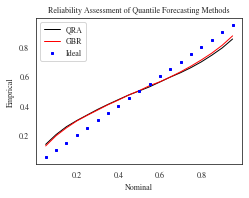

In [ ]:
plt.plot(QUANTILES,QR_Calibration,color='black',label='QRA')
plt.plot(QUANTILES,GB_Calibration,color='red',label='GBR')
plt.plot(QUANTILES,QUANTILES,'bs',label='Ideal')
plt.xlabel('Nominal')
plt.ylabel('Emprical')
plt.legend()
plt.title('Reliability Assessment of Quantile Forecasting Methods')
#plt.savefig('Reliability.png',dpi=300)
#files.download('Reliability.png')

# **Sharpness**

In [ ]:
I=np.array([90,80,70,60,50,40,30,20,10])
#QRA
col=QR.columns
l=len(col)
t=1
for i in I:
  QR['I={}'.format(i)]=QR[col[l-t]]-QR[col[t]]
  t+=1
col=QR.columns
l1=len(col)
l2=len(QUANTILES)+1
col=col[l2:l1]
#GB
col=GB.columns
l=len(col)
t=1
for i in I:
  GB['I={}'.format(i)]=GB[col[l-t]]-GB[col[t]]
  t+=1
col=GB.columns
l1=len(col)
l2=len(QUANTILES)+1
col=col[l2:l1]

a1=GB[col].mean()
a2=QR[col].mean()

print('Sharpness of QR:',a2.mean())
print('Sharpness of GB:',a1.mean())


Sharpness of QR: 353.09800168821937
Sharpness of GB: 384.43495697274426


# **CRPS**

In [ ]:
#QR
col=QR.columns[1:len(QUANTILES)+1]
s=0
for c in col:
  s+=(QR[c]-QR['label'])**2
s=s*0.5
QR['CRPS']=s
a1=QR['CRPS'].mean()

#GB
col=GB.columns[1:len(QUANTILES)+1]
s=0
for c in col:
  s+=(GB[c]-GB['label'])**2
s=s*0.5
GB['CRPS']=s
a2=GB['CRPS'].mean()

print('CRPS of QR:',a1)
print('CRPS of GB:',a2)

CRPS of QR: 2552953.4604650717
CRPS of GB: 2672242.0117056393


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

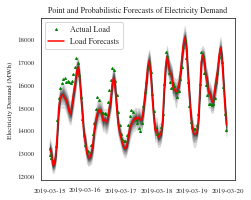

In [ ]:
p='2019-03-15'
q='2019-03-19'
a=0.1
q1=GB[p:q]['q=0.05']
q2=GB[p:q]['q=0.95']
plt.fill_between(q1.index,q1,q2,color='black',alpha=a)

q3=GB[p:q]['q=0.1']
q4=GB[p:q]['q=0.9']
plt.fill_between(q1.index,q3,q4,color='black',alpha=a)

q3=GB[p:q]['q=0.15']
q4=GB[p:q]['q=0.85']
plt.fill_between(q1.index,q3,q4,color='black',alpha=a)

q3=GB[p:q]['q=0.2']
q4=GB[p:q]['q=0.8']
plt.fill_between(q1.index,q3,q4,color='black',alpha=a)

q3=GB[p:q]['q=0.25']
q4=GB[p:q]['q=0.75']
plt.fill_between(q1.index,q3,q4,color='black',alpha=a)

q3=GB[p:q]['q=0.3']
q4=GB[p:q]['q=0.7']
plt.fill_between(q1.index,q3,q4,color='black',alpha=a)

q3=GB[p:q]['q=0.35']
q4=GB[p:q]['q=0.65']
plt.fill_between(q1.index,q3,q4,color='black',alpha=a)

q3=GB[p:q]['q=0.4']
q4=GB[p:q]['q=0.6']
plt.fill_between(q1.index,q3,q4,color='black',alpha=a)

q3=GB[p:q]['q=0.45']
q4=GB[p:q]['q=0.55']
plt.fill_between(q1.index,q3,q4,color='black',alpha=a)

plt.rcParams['font.size']=7
plt.rcParams['figure.autolayout']=True
plt.rcParams['axes.titlesize']=8
plt.rcParams['axes.labelsize']=7
plt.rcParams['lines.linewidth']=1
plt.rcParams['lines.markersize']=2
plt.rcParams['legend.fontsize']=8
plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['mathtext.fontset']='custom'
plt.rcParams['legend.numpoints']=1

plt.plot(GB[p:q]['label'],'g^',lw=1,markersize=2,label='Actual Load')
plt.plot(DF[p:q]['XGB'],color='red',lw=1.5,label='Load Forecasts')
plt.legend()
plt.ylabel('Electricity Demand (MWh)')
plt.title('Point and Probabilistic Forecasts of Electricity Demand')
plt.savefig('QuantileLoad.png',dpi=300)
files.download('QuantileLoad.png')